In [226]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, least_squares, minimize
import matplotlib.pyplot as plt
from importlib import reload
import OptionPricers
reload(OptionPricers)
from OptionPricers import Black76Call, Black76Put, DisplacedDiffusionCall, DisplacedDiffusionPut, SABR
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [227]:
swaption_df = pd.read_excel("data/IR Data.xlsx", sheet_name="Swaption", header=2)
swaption_df

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297
1,1Y,2Y,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
2,1Y,3Y,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833
3,1Y,5Y,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
4,1Y,10Y,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
5,5Y,1Y,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980
6,5Y,2Y,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760
7,5Y,3Y,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150
8,5Y,5Y,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400
9,5Y,10Y,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250


In [228]:
__tenors__ = [1,2,3,5,10]
__strikes__ = [-200, -150, -100, -50, -25, 0, 25, 50, 100, 150, 200]
__expiries__ = [1,5,10]

In [229]:
# forward swap rates from part 1
swap_rates_df = pd.read_excel("data/swap_rates.xlsx", sheet_name="swap_rates", index_col=0) # expiry x tenor
swap_rates_df.columns = swap_rates_df.columns.astype('int64')
swap_rates_df


,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


In [230]:
# forward swap pv01 from part 1
pv01_df = pd.read_excel("data/swap_rates.xlsx", sheet_name="pv01", index_col=0) # expiry x tenor
pv01_df.columns = pv01_df.columns.astype('int64')
pv01_df


,1,2,3,5,10
1,0.994400,1.985294,2.972386,4.934070,9.747887
5,0.978517,1.952145,2.920444,4.840612,9.542492
10,0.951722,1.897771,2.838147,4.701880,9.264214


In [231]:
model_input = swaption_df.melt(id_vars=['Expiry','Tenor']
                            ,var_name='Strike'
                            ,value_name='Volatility')
tenor_dict = {
    "1Y": 1,
    "2Y": 2,
    "3Y": 3,
    "5Y": 5,
    "10Y": 10
    }
strike_dict = {
    "-200bps": -200,
    "-150bps": -150,
    "-100bps": -100,
    "-50bps": -50,
    "-25bps": -25,
    "ATM": 0,
    "+25bps": 25,
    "+50bps": 50,
    "+100bps": 100,
    "+150bps": 150,
    "+200bps": 200
}
model_input.replace({
    "Expiry": tenor_dict,
    "Tenor": tenor_dict,
    "Strike": strike_dict
    }, inplace=True)

model_input["Volatility"] = model_input["Volatility"]*1E-2

for idx, row in model_input.iterrows():
    expiry = row["Expiry"]
    tenor = row["Tenor"]
    model_input.at[idx, "Swap Rate"] = swap_rates_df[tenor][expiry]
    model_input.at[idx, "PV01"] = pv01_df[tenor][expiry]

model_input = model_input.sort_values(["Expiry","Tenor","Strike"])\
                         .reset_index(drop=True)
model_input.head(15)

/var/folders/ys/nqq2g2_n2td1rcfs2z3h80zm0000gn/T/ipykernel_935/1838227828.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_input.replace({


,Expiry,Tenor,Strike,Volatility,Swap Rate,PV01
0,1,1,-200,0.91570,0.032007,0.994400
1,1,1,-150,0.62030,0.032007,0.994400
2,1,1,-100,0.44130,0.032007,0.994400
3,1,1,-50,0.31224,0.032007,0.994400
4,1,1,-25,0.26182,0.032007,0.994400
5,1,1,0,0.22500,0.032007,0.994400
6,1,1,25,0.20960,0.032007,0.994400
7,1,1,50,0.21400,0.032007,0.994400
8,1,1,100,0.24340,0.032007,0.994400
9,1,1,150,0.27488,0.032007,0.994400


In [232]:
def implied_vol(F: float, K: float, price: float, T: float, D: float):
    """
    Calculate implied volatility based on market price

    Args:
    F(float): forward price
    K(float): strike price
    price(float): option price (mid price)
    T(float): time to expiry (in years)
    D(float): DF or PV01

    Returns:
    implied vol
    """
    try:
        if K >= F:
            iv = brentq(lambda x: price -
                                Black76Call(F, K, x, T, D),
                                1E-12, 10)
        else:
            iv = brentq(lambda x: price -
                                Black76Put(F, K, x, T, D),
                                1E-12, 10)
    except Exception as error:
            print(f"Exception at F={F}, K={K}, price={price}, T={T}, D={D}.")      
            raise error
    return iv

def dd_loss_func(x: list, strikes: float, market_vols: list, F: float, sigma: float, T:float, D: float):
    """
    To obtain the total squared error between estimated and actual prices

    Args:
    x(list): DD parameters - beta
    strikes(float): K
    market_vols(list): realized vols
    F(float): forward price
    sigma(float): vol
    T(float): time to expiry (in years)
    D(float): DF or PV01

    Returns:
    Total error from list of vols 
    """
    err = 0.0

    for K, vol in zip(strikes, market_vols):
        beta = x[0]
        try:
            if K>=F:
                V_dd = DisplacedDiffusionCall(F, K, sigma, beta, T, D)
            else: 
                V_dd = DisplacedDiffusionPut(F, K, sigma, beta, T, D)
            
            iv_dd = implied_vol(F, K, V_dd, T, D)

        except Exception as error:
            print(f"Exception at F={F}, K={K}, sigma={sigma}, beta={beta}, T={T}, D={D}.")      
            raise error
        
        err+=(vol-iv_dd)**2      
    
    return err

# def dd_loss_func(x: list, strikes: float, market_vols: list, F: float, T:float, D: float):
#     """
#     To obtain the total squared error between estimated and actual prices

#     Args:
#     x(list): DD parameters - sigma, beta
#     strikes(float): K
#     market_vols(list): realized vols
#     F(float): forward price
#     sigma(float): vol
#     T(float): tenor (in years)
#     D(float): DF or PV01

#     Returns:
#     Total error from list of vols 
#     """
#     err = 0.0

#     for K, vol in zip(strikes, market_vols):
#         sigma = x[0]
#         beta = x[1]
#         try:
#             if K>=F:
#                 V_dd = DisplacedDiffusionCall(F, K, sigma, beta, T, D)
#             else: 
#                 V_dd = DisplacedDiffusionPut(F, K, sigma, beta, T, D)
#             iv_dd = implied_vol(F, K, V_dd, T, D)
#         except Exception as error:
#             print(f"Exception at F={F}, K={K}, sigma={sigma}, beta={beta}, T={T}, D={D}.")      
#             raise error
#         err+=(vol-iv_dd)**2      
#     return err

In [233]:
dd_sigma = pd.DataFrame(
                [model_input[(model_input["Expiry"]==1)
                            &(model_input["Strike"]==0)
                            ]["Volatility"].values,
                 model_input[(model_input["Expiry"]==5)
                            &(model_input["Strike"]==0)
                            ]["Volatility"].values,
                 model_input[(model_input["Expiry"]==10)
                            &(model_input["Strike"]==0)
                            ]["Volatility"].values]
                , index=__expiries__ 
                , columns=__tenors__  
                )
dd_sigma # ATM vol

,1,2,3,5,10
1,0.2250,0.2872,0.2978,0.2607,0.2447
5,0.2726,0.2983,0.2998,0.2660,0.2451
10,0.2854,0.2928,0.2940,0.2674,0.2437


In [213]:
dd_beta = pd.DataFrame(
                index=__expiries__ # expiry
                , columns=__tenors__ # tenor
                )
for expiry in __expiries__:
    for tenor in __tenors__:
        df = model_input[(model_input["Expiry"]==expiry)
                        &(model_input["Tenor"]==tenor)]
        strikes = df["Swap Rate"].values + df["Strike"].values*1E-4
        market_vols = df["Volatility"].values
        atm_vol = dd_sigma[tenor][expiry]
        swap_rate = df["Swap Rate"].values[0]
        pv01 = df["PV01"].values[0]
        res = least_squares(lambda x: dd_loss_func(x,
                                                    strikes, 
                                                    market_vols,
                                                    swap_rate,
                                                    atm_vol, 
                                                    expiry,
                                                    pv01), 
                            [0.1], # initial guess
                            bounds = (1E-12,0.99))
        # res = minimize(dd_loss_func, 
        #                [0.3], # initial guess
        #                args=(strikes, 
        #                      market_vols, 
        #                      swap_rate, 
        #                      atm_vol,
        #                      tenor,
        #                      pv01),
        #                bounds=[(0.01, 0.99)], 
        #                method='L-BFGS-B')
        dd_beta.at[expiry, tenor] = res.x[0]
                           
dd_beta


,1,2,3,5,10
1,0.0,0.0,0.000005,0.000003,0.000022
5,0.000002,0.0,0.000001,0.000016,0.057859
10,0.0,0.000002,0.000014,0.000065,0.005126


In [215]:
for idx, row in model_input.iterrows():
    expiry = row["Expiry"]
    tenor = row["Tenor"]
    swap_rate = row["Swap Rate"]
    pv01 = row["PV01"]
    strike = row["Swap Rate"] + row["Strike"]*1E-4
    beta = dd_beta[tenor][expiry]
    sigma = dd_sigma[tenor][expiry]
    try:
        if strike >= swap_rate:
            price = DisplacedDiffusionCall(swap_rate, 
                                            strike, 
                                            sigma, 
                                            beta, 
                                            expiry, 
                                            pv01)
        else:
            price = DisplacedDiffusionPut(swap_rate, 
                                            strike, 
                                            sigma, 
                                            beta, 
                                            expiry, 
                                            pv01)
        iv = implied_vol(swap_rate,
                            strike, 
                            price, 
                            expiry, 
                            pv01)
    except Exception as error:
        print(f"Exception at F={swap_rate}, K={strike}, sigma={sigma}, beta={beta}, T={expiry}, D={pv01}, N={tenor}.")      
        raise error
    model_input.at[idx, "DD Price"] = price
    model_input.at[idx, "DD Implied Vol"] = iv

model_input

,Expiry,Tenor,Strike,Volatility,Swap Rate,PV01,DD Price,DD Implied Vol
0,1,1,-200,0.91570,0.032007,0.994400,0.000006,0.355144
1,1,1,-150,0.62030,0.032007,0.994400,0.000049,0.305020
2,1,1,-100,0.44130,0.032007,0.994400,0.000269,0.270546
3,1,1,-50,0.31224,0.032007,0.994400,0.001033,0.245247
4,1,1,-25,0.26182,0.032007,0.994400,0.001784,0.234805
5,1,1,0,0.22500,0.032007,0.994400,0.002857,0.225462
6,1,1,25,0.20960,0.032007,0.994400,0.001784,0.217065
7,1,1,50,0.21400,0.032007,0.994400,0.001033,0.209445
8,1,1,100,0.24340,0.032007,0.994400,0.000269,0.196134
9,1,1,150,0.27488,0.032007,0.994400,0.000049,0.184803


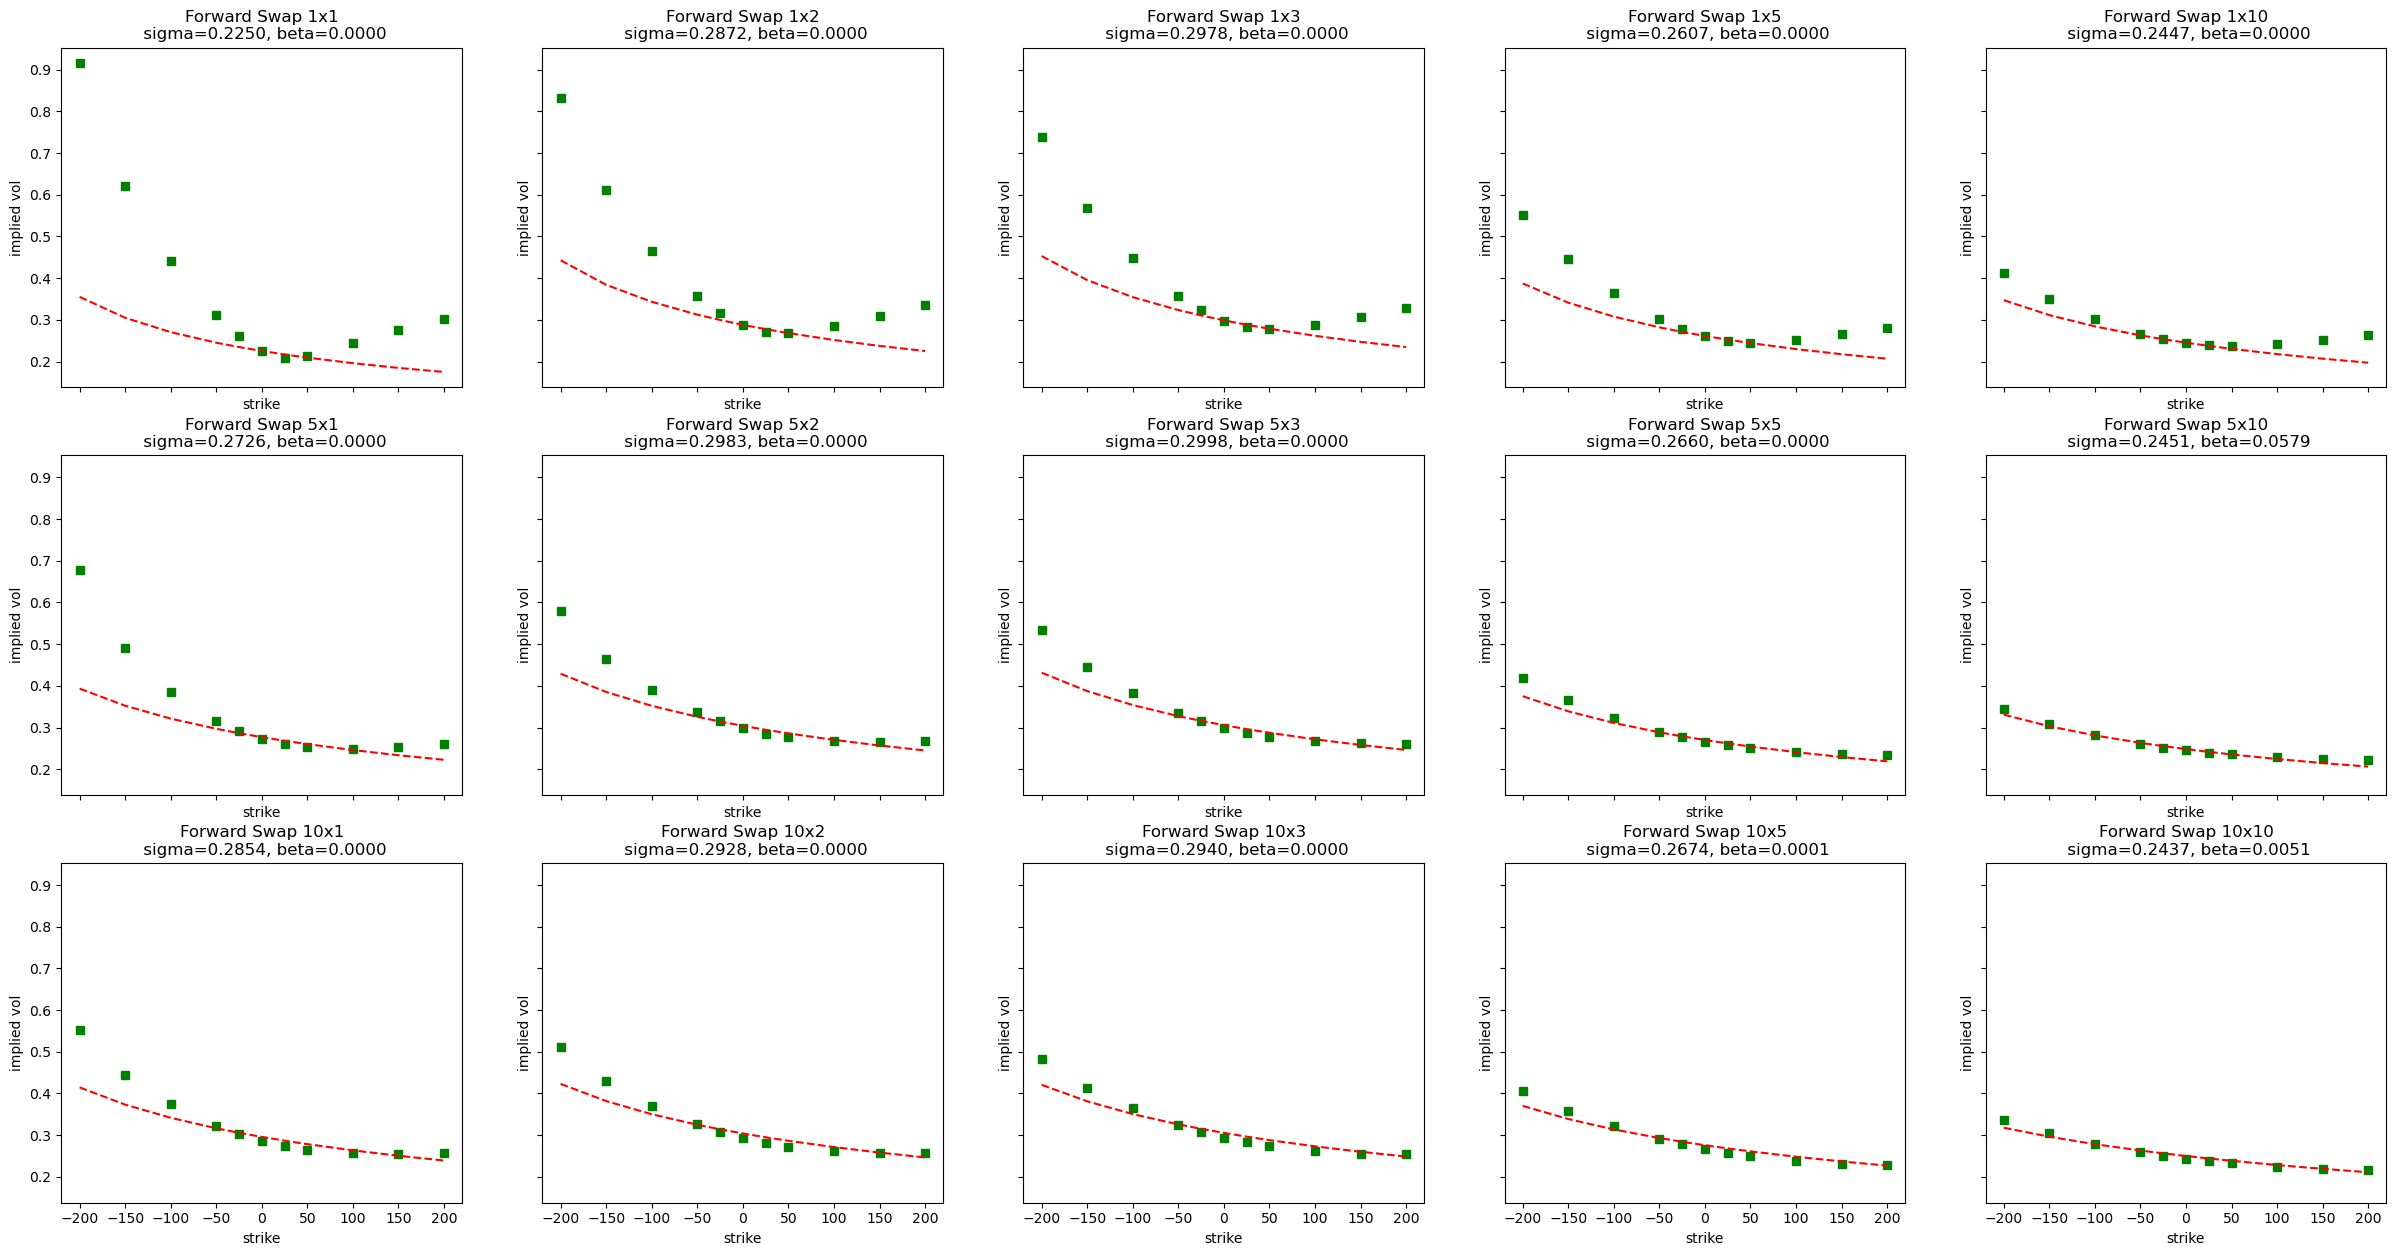

In [216]:
fig, axs = plt.subplots(3, 5, 
                        sharex=True, sharey=True,
                        figsize=(30, 15))
for r, expiry in enumerate(__expiries__):
    for c, tenor in enumerate(__tenors__):
        plot_df = model_input[(model_input["Expiry"]==expiry) 
                                   & (model_input["Tenor"]==tenor)]
        sigma = dd_sigma[tenor][expiry]
        beta = dd_beta[tenor][expiry]
        axs[r, c].plot(__strikes__, plot_df["Volatility"], 's', color='green', label='realized vol')
        axs[r, c].plot(__strikes__, plot_df["DD Implied Vol"], color='red', linestyle='--', label=f'DD model')
        axs[r, c].set_title(f'Forward Swap {expiry}x{tenor}\n sigma={sigma:.4f}, beta={beta:.4f}')

for ax in axs.flat:
    ax.set(xlabel='strike', ylabel='implied vol')

In [234]:
__beta__ = 0.9

def sabr_loss_func(x, strikes, market_vols, F, T):
    err = 0.0
    for K, vol in zip(strikes, market_vols):
        err += (vol - SABR(F, K, T,
                           x[0], __beta__, x[1], x[2]))**2

    return err

In [239]:
sabr_alpha = pd.DataFrame(
                    index=__expiries__
                    , columns=__tenors__
                    )
sabr_rho = pd.DataFrame(
                    index=__expiries__
                    , columns=__tenors__
                    )
sabr_nu = pd.DataFrame(
                    index=__expiries__
                    , columns=__tenors__
                    )
for expiry in __expiries__:
    for tenor in __tenors__:
        df = model_input[(model_input["Expiry"]==expiry)
                              &(model_input["Tenor"]==tenor)]
        strikes = df["Swap Rate"].values + df["Strike"].values*1E-4
        market_vols = df["Volatility"].values
        swap_rate = df["Swap Rate"].values[0]
        # res = least_squares(lambda x: sabr_loss_func(x,
        #                                              strikes,
        #                                              market_vols,
        #                                              swap_rate,
        #                                              expiry),
        #                     # [0.2, 0.0, 0.5]) # initial guess
        #                     [0.15, -0.6, 1.3]) # initial guess

        res = minimize(sabr_loss_func, 
                       [0.2, 0.0, 0.5], # initial guess
                       args=(strikes, 
                             market_vols, 
                             swap_rate, 
                             tenor),
                       bounds=[(0.01, None), (-0.99, 0.99), (0.01, None)], 
                       method='L-BFGS-B')
        sabr_alpha.at[expiry, tenor] = res.x[0]
        sabr_rho.at[expiry, tenor] = res.x[1]
        sabr_nu.at[expiry, tenor] = res.x[2]

In [240]:
sabr_alpha

,1,2,3,5,10
1,0.399092,0.173901,0.179499,0.157859,0.141834
5,0.186163,0.208172,0.212818,0.190592,0.17285
10,0.202993,0.209371,0.212796,0.198442,0.176504


In [241]:
sabr_rho

,1,2,3,5,10
1,-0.812883,-0.526005,-0.484602,-0.416708,-0.262032
5,-0.584679,-0.545032,-0.548168,-0.508776,-0.42784
10,-0.543864,-0.542612,-0.548563,-0.55728,-0.490385


In [242]:
sabr_nu

,1,2,3,5,10
1,6.327976,1.583221,1.315466,0.947659,0.654595
5,1.48602,1.102204,0.944242,0.673388,0.498041
10,1.136284,0.978334,0.880044,0.707839,0.586748


In [223]:
for idx, row in model_input.iterrows():
    expiry = row["Expiry"]
    tenor = row["Tenor"]
    swap_rate = row["Swap Rate"]
    strike = row["Swap Rate"] + row["Strike"]*1E-4
    alpha = sabr_alpha[tenor][expiry]
    rho = sabr_rho[tenor][expiry]
    nu = sabr_nu[tenor][expiry]
    iv = SABR(swap_rate, strike, expiry, alpha, __beta__, rho, nu)
    model_input.at[idx, "SABR Implied Vol"] = iv

model_input

,Expiry,Tenor,Strike,Volatility,Swap Rate,PV01,DD Price,DD Implied Vol,SABR Implied Vol
0,1,1,-200,0.91570,0.032007,0.994400,0.000006,0.355144,0.833977
1,1,1,-150,0.62030,0.032007,0.994400,0.000049,0.305020,0.638931
2,1,1,-100,0.44130,0.032007,0.994400,0.000269,0.270546,0.482160
3,1,1,-50,0.31224,0.032007,0.994400,0.001033,0.245247,0.345198
4,1,1,-25,0.26182,0.032007,0.994400,0.001784,0.234805,0.281605
5,1,1,0,0.22500,0.032007,0.994400,0.002857,0.225462,0.224209
6,1,1,25,0.20960,0.032007,0.994400,0.001784,0.217065,0.190322
7,1,1,50,0.21400,0.032007,0.994400,0.001033,0.209445,0.195576
8,1,1,100,0.24340,0.032007,0.994400,0.000269,0.196134,0.242894
9,1,1,150,0.27488,0.032007,0.994400,0.000049,0.184803,0.291487


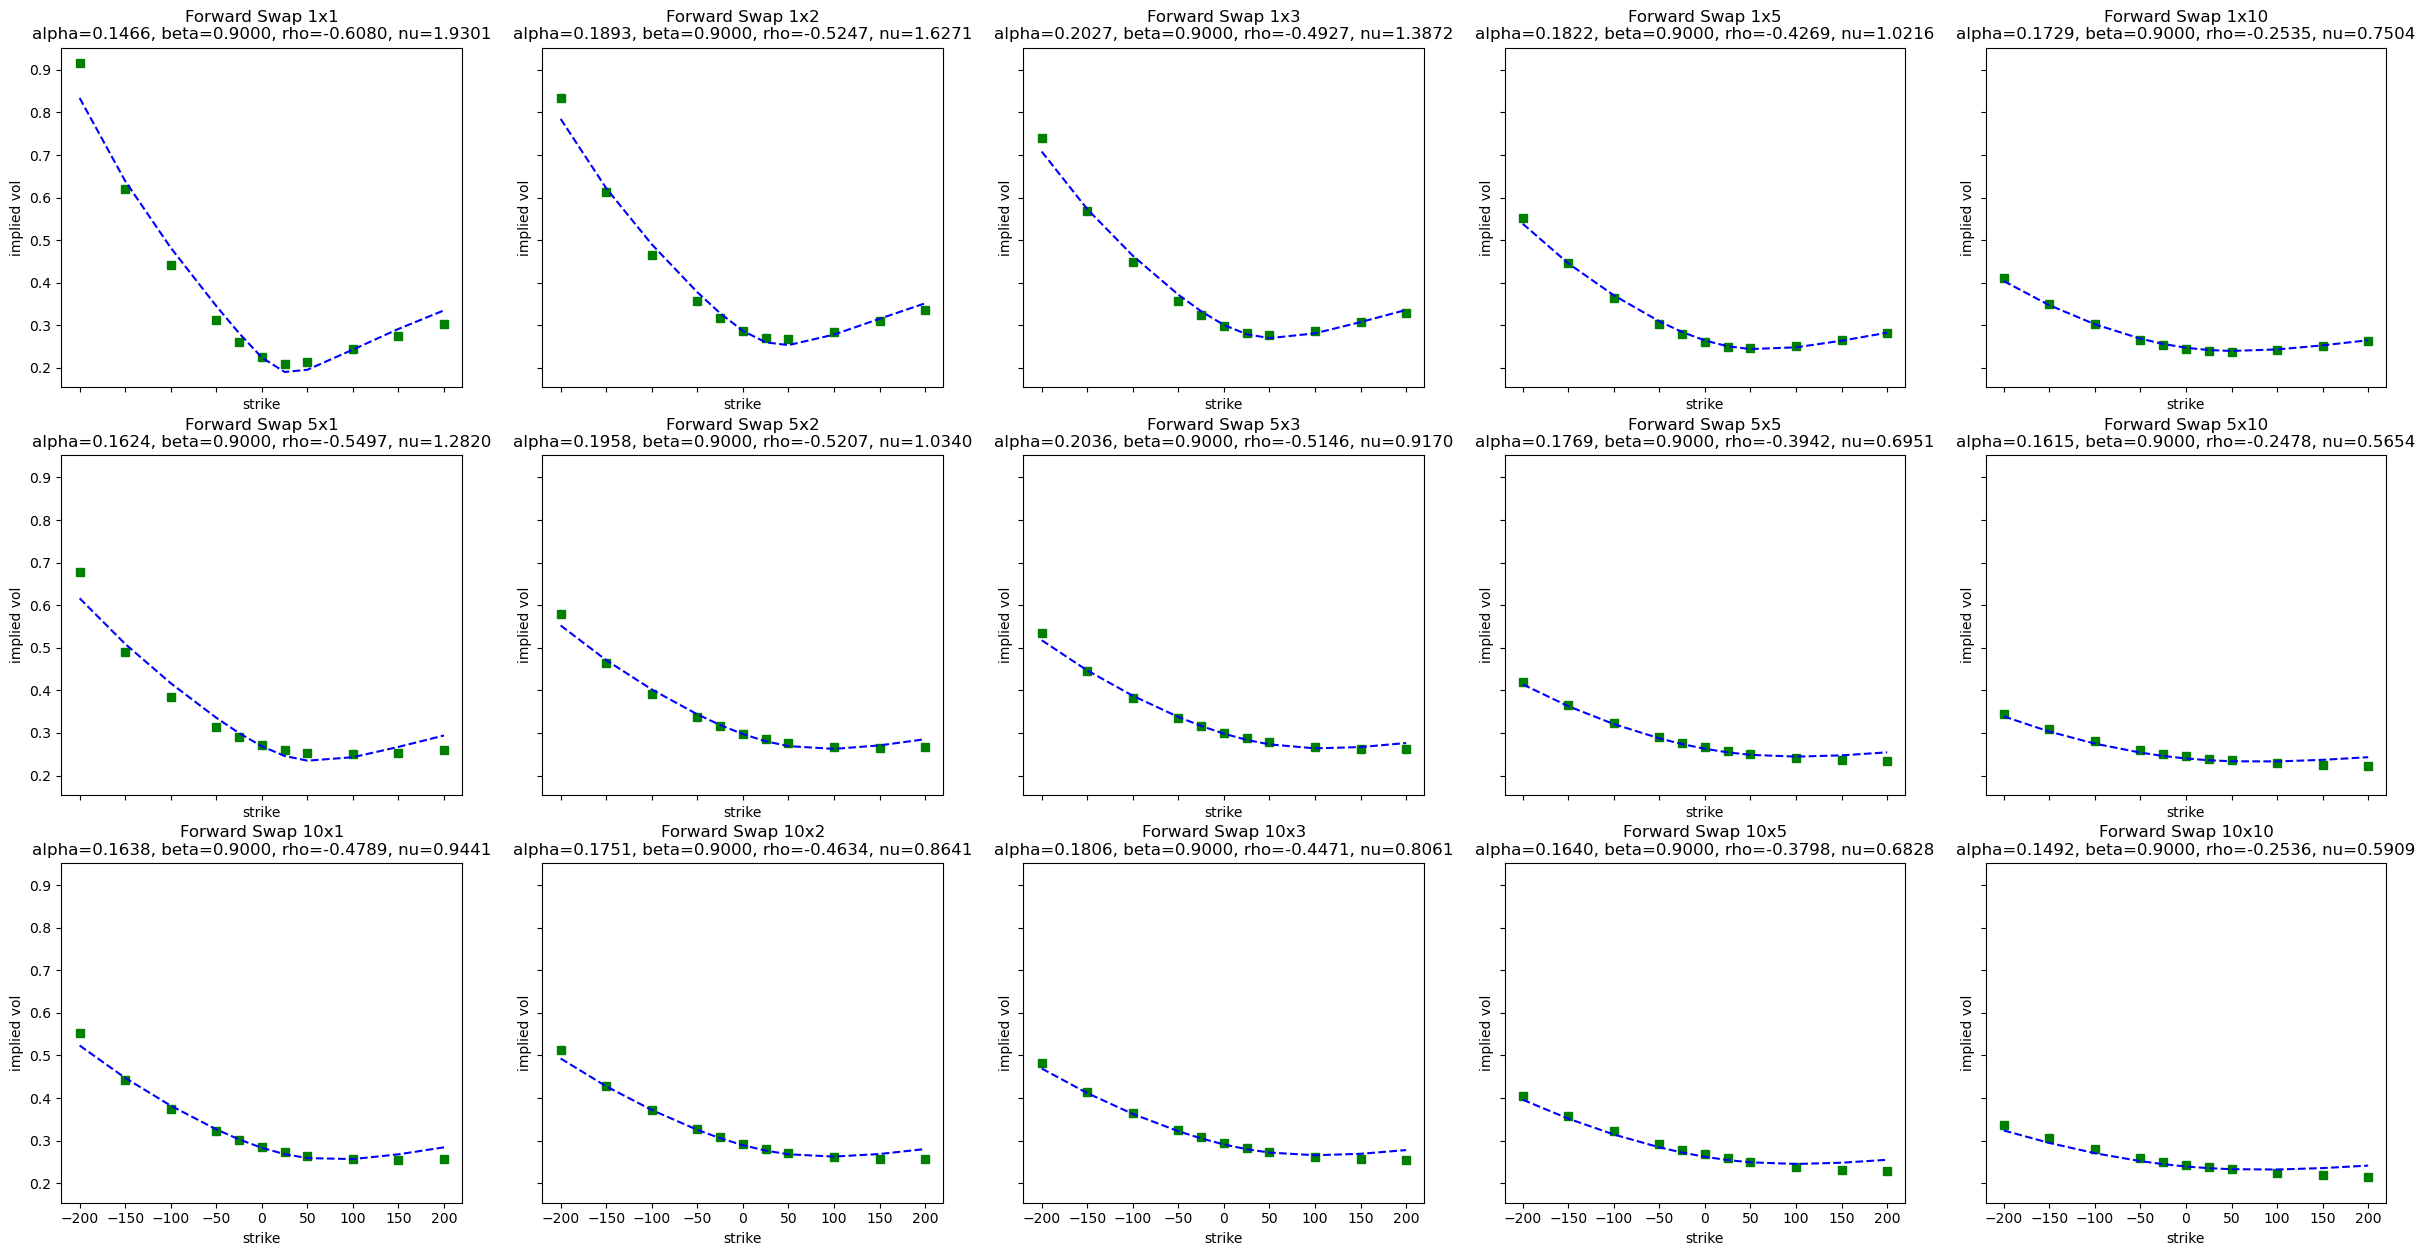

In [224]:
fig, axs = plt.subplots(3, 5, 
                        sharex=True, sharey=True,
                        figsize=(30, 15))
for r, expiry in enumerate(__expiries__):
    for c, tenor in enumerate(__tenors__):
        plot_df = model_input[(model_input["Expiry"]==expiry) 
                                   & (model_input["Tenor"]==tenor)]
        alpha = sabr_alpha[tenor][expiry]
        rho = sabr_rho[tenor][expiry]
        nu = sabr_nu[tenor][expiry]
        axs[r, c].plot(__strikes__, plot_df["Volatility"], 's', color='green', label='realized vol')
        axs[r, c].plot(__strikes__, plot_df["SABR Implied Vol"], color='blue', linestyle='--', label=f'SABR model')
        axs[r, c].set_title(f'Forward Swap {expiry}x{tenor}\nalpha={alpha:.4f}, beta={__beta__:.4f}, rho={rho:.4f}, nu={nu:.4f}')

for ax in axs.flat:
    ax.set(xlabel='strike', ylabel='implied vol')

In [225]:
with pd.ExcelWriter("data/model_calibration.xlsx", mode='w') as writer:  
    dd_sigma.to_excel(writer, sheet_name="dd_sigma")
    dd_beta.to_excel(writer, sheet_name="dd_beta")
    sabr_alpha.to_excel(writer, sheet_name="sabr_alpha")
    sabr_rho.to_excel(writer, sheet_name="sabr_rho")
    sabr_nu.to_excel(writer, sheet_name="sabr_nu")